<h1><center> Coursera Capstone Project : The battle of Neighborhoods </center></h1>
<p style="margin-left:45%"><i>As part of the IBM Data Science Professional Certificate program</i></p>

## Introduction

IBM Data Science Specialization, is a set of courses offered by IBM as part of a professional certification in Data Science. This training starts from the foundations of Data Science and ends with a Capstone project where the student is led to carry out a complete Data Science project on real cases and real data of his choice. The theme of the project revolves around location data with the Foursquare API. Each student picks a specific problem of his choice which is related to the analysis of neighborhoods. In our case, we have chosen to segment and cluster the Casablanca tram stations.

## Table of Content

1. <a href="#item1">Business Problem</a>      
2. <a href="#item2">Data Description</a><br>
    2.1 <a href="#item2_1">Import libraries</a><br>
    2.2 <a href="#item2_2">Load Datasets</a><br>
    2.3 <a href="#item2_3">Data processing</a><br>
    2.4 <a href="#item2_4">Foursquare API</a><br>
3. <a href="#item3">Methodology</a><br>
    3.1 <a href="#item3_1">Exploratory analysis</a><br>
    3.2 <a href="#item3_2">Clustering</a><br>
4. <a href="#item4">Results</a>
5. <a href="#item5">Discussion</a>
6. <a href="#item6">Conclusion</a>

<a id='item1'></a>

## 1. Business Problem

Casablanca is a city which, in the last century, has seen a remarkable evolution in terms of area, population and activities. However, despite becoming an economic capital, its first modern tram network was not put into service until 2012. This network currently includes two lines commissioned and two lines under construction.


Through this Capstone project, we will focus on the two lines of Casa Tramaway that are in service, namely the T1 line and the T2 line. Then, we will analyze the surroundings of each station, segment them by district and cluster them in order of priority and/or activity. This segmentation could possibly help in the optimization of stations on future lines.

<a id='item2'></a>

## 2. Data Decription

For this analysis we will need:
- The list of Casa Tramway stations with their coordinates,
- The names of Boroughs and Neighborhoods in which belongs the stations,
- The venues surroundings each station.

Unfortunately we didn't find any page or document on the web which provides the coordinates of the stations, this is why we created the <a href="https://raw.githubusercontent.com/kenzaboutaleb/Tramway_Stations_Segmentation/master/geogata_station.csv">geodata_stations</a> file containing the name of the station, the line to which it belongs, the coordinates and the neighborhoods. 

We may need the boroughs that we can find on the following pages: https://fr.wikipedia.org/wiki/Ligne_1_du_tramway_de_Casablanca for line 1, https://fr.wikipedia.org/wiki/Ligne_2_du_tramway_de_Casablanca for line 2.

Finally, we will use the Foursquare API to get the venues next to the stations.

<a id='item2_1'></a>

### 2.1 Import libraries 

In [63]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import folium
from geopy.geocoders import Nominatim
import geocoder

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

<a id='item2_2'></a>

### 2.2 Load Datasets

Let's start by loading geodata_stations file. The file structure is as follow:
- **Station:** Name of the station,
- **Ligne:** Line abbreviation, *T1* or *T1*,
- **Lat:** latitude coordinates,
- **Long:** Longitude coordinates,
- **Quartier:** Name of the Neighborhood.

In [2]:
stations = pd.read_csv("https://raw.githubusercontent.com/kenzaboutaleb/Tramway_Stations_Segmentation/master/geogata_station.csv", sep = ";")
stations.head()

,Station,Ligne,lat,long,Quartier
0,Sidi Moumen,T1,33.587459,-7.500901,Sidi Moumen
1,Nassim,T1,33.585144,-7.504294,Sidi Moumen
2,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen
3,Centre de maintenance,T1,33.579540,-7.513432,Sidi Moumen
4,Hôpital Sidi Moumen,T1,33.576385,-7.518045,Sidi Moumen


The names of the columns are in French, let's assign to them English names.

In [3]:
stations.rename(columns={"Station": "Station", "Ligne": "Line", "lat": "Latitude","long":"Longitude","Quartier":"Neighborhood"}, inplace = True)
list(stations)

['Station', 'Line', 'Latitude', 'Longitude', 'Neighborhood']

This file contains the names of the neighborhoods but not the districts. In order to constitute a complete dataset, we are going to combine this dataframe with the list of boroughs.

The first <a href="https://fr.wikipedia.org/wiki/Ligne_1_du_tramway_de_Casablanca">table</a> contains information on the stations of line T1, the fields are:  
- **Station:** Name of the station,
- **Coordonnées:** Coordinates,
- **Arrondissement:** Borough,
- **Correspondances:** Bus and/or tram stations which are in correspondence with the tram station.

In [4]:
page = requests.get("https://fr.wikipedia.org/wiki/Ligne_1_du_tramway_de_Casablanca") #Download page
soup = BeautifulSoup(page.content, 'html.parser') #Parsing with BeautifulSoup
table = soup.findAll('table')[1]
line_1 = pd.read_html(str(table))[0] #Transform to Dataframe
line_1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Station,Coordonnées,Arrondissement,Correspondances
0,NaN,NaN,o,NaN,NaN,Sidi Moumen,"33° 35′ 14″ N, 7° 30′ 04″ O",Sidi Moumen,"Bus 33, 75, 97, 97, 105, 501"
1,NaN,NaN,o,NaN,NaN,Nassim,"33° 35′ 05″ N, 7° 30′ 18″ O",Sidi Moumen,"Bus 75, 97, 105"
2,NaN,NaN,o,NaN,NaN,Mohammed Zefzaf,"33° 34′ 56″ N, 7° 30′ 31″ O",Sidi Moumen,"Bus 75, 97, 105"
3,NaN,NaN,o,NaN,NaN,Centre de maintenance,"33° 34′ 45″ N, 7° 30′ 48″ O",Sidi Moumen,"Bus 75, 97, 105"
4,NaN,NaN,o,NaN,NaN,Hôpital Sidi Moumen,"33° 34′ 35″ N, 7° 31′ 05″ O",Sidi Moumen,"Bus 75, 97, 105"


The second <a href="https://fr.wikipedia.org/wiki/Ligne_2_du_tramway_de_Casablanca">table</a> contains information on the stations of line T2, the fields are:  
- **Stations:** Name of the station,
- **Lat/Long:** Coordinates,
- **Arrondissement:** Borough,
- **Correspondances:** Bus and/or tram stations which are in correspondence with the tram station.

In [5]:
page = requests.get("https://fr.wikipedia.org/wiki/Ligne_2_du_tramway_de_Casablanca") #Download page
soup = BeautifulSoup(page.content, 'html.parser') #Parsing with BeautifulSoup
table = soup.findAll('table')[1]
line_2 = pd.read_html(str(table))[0] #Transform to Dataframe
line_2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Stations,Lat/Long,Arrondissement,Correspondances
0,NaN,o,NaN,Aïn Diab,NaN,Anfa,NaN
1,NaN,o,NaN,Littoral,NaN,Anfa,NaN
2,NaN,o,NaN,Hay Hassani,NaN,Hay Hassani,NaN
3,NaN,o,NaN,Sidi Abderrahmane,NaN,Hay Hassani,NaN
4,NaN,o,NaN,Cité de l'Air,NaN,Hay Hassani,NaN


<a id='item2_3'></a>

### 2.3 Data Processing

Let’s remove the fields created following tabulations, namely Unnamed: 0, Unnamed: 1, etc. Next we will assign the same column names to the two tables.

In [6]:
line_1 = line_1.iloc[:,5:9]
line_1.rename(columns={"Station": "Station", "Coordonnées": "Coordinates", "Arrondissement": "Borough","Correspondances":"Correspondence"}, inplace = True)
line_1.head()

,Station,Coordinates,Borough,Correspondence
0,Sidi Moumen,"33° 35′ 14″ N, 7° 30′ 04″ O",Sidi Moumen,"Bus 33, 75, 97, 97, 105, 501"
1,Nassim,"33° 35′ 05″ N, 7° 30′ 18″ O",Sidi Moumen,"Bus 75, 97, 105"
2,Mohammed Zefzaf,"33° 34′ 56″ N, 7° 30′ 31″ O",Sidi Moumen,"Bus 75, 97, 105"
3,Centre de maintenance,"33° 34′ 45″ N, 7° 30′ 48″ O",Sidi Moumen,"Bus 75, 97, 105"
4,Hôpital Sidi Moumen,"33° 34′ 35″ N, 7° 31′ 05″ O",Sidi Moumen,"Bus 75, 97, 105"


In [7]:
line_2 = line_2.iloc[:,3:7]
line_2.rename(columns={"Stations": "Station", "Lat/Long": "Coordinates", "Arrondissement": "Borough","Correspondances":"Correspondence"}, inplace = True)
line_2.head()

,Station,Coordinates,Borough,Correspondence
0,Aïn Diab,NaN,Anfa,NaN
1,Littoral,NaN,Anfa,NaN
2,Hay Hassani,NaN,Hay Hassani,NaN
3,Sidi Abderrahmane,NaN,Hay Hassani,NaN
4,Cité de l'Air,NaN,Hay Hassani,NaN


The coordinate and correspondence fields are not reliable and contain many null values, so we will remove them.

In [8]:
line_1.drop(columns=['Coordinates', 'Correspondence'],inplace = True)
line_2.drop(columns=['Coordinates', 'Correspondence'],inplace = True)

In [9]:
line_1.head()

,Station,Borough
0,Sidi Moumen,Sidi Moumen
1,Nassim,Sidi Moumen
2,Mohammed Zefzaf,Sidi Moumen
3,Centre de maintenance,Sidi Moumen
4,Hôpital Sidi Moumen,Sidi Moumen


In [10]:
line_2.head()

,Station,Borough
0,Aïn Diab,Anfa
1,Littoral,Anfa
2,Hay Hassani,Hay Hassani
3,Sidi Abderrahmane,Hay Hassani
4,Cité de l'Air,Hay Hassani


The last step now is to combine these last two dataframes with the dataframe ***stations***.

In [11]:
temp = pd.concat([line_1,line_2])
DF = pd.merge(stations,temp, on='Station')
DF

,Station,Line,Latitude,Longitude,Neighborhood,Borough
0,Sidi Moumen,T1,33.587459,-7.500901,Sidi Moumen,Sidi Moumen
1,Nassim,T1,33.585144,-7.504294,Sidi Moumen,Sidi Moumen
2,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen,Sidi Moumen
3,Centre de maintenance,T1,33.579540,-7.513432,Sidi Moumen,Sidi Moumen
4,Hôpital Sidi Moumen,T1,33.576385,-7.518045,Sidi Moumen,Sidi Moumen
...,...,...,...,...,...,...
65,Al Aman,T2,33.599227,-7.532880,Aïn Sebaa,Aïn Sebaâ
66,Préfecture d'Aïn Sebaâ,T2,33.602354,-7.529857,Aïn Sebaa,Aïn Sebaâ
67,Gare d'Aïn Sebaâ,T2,33.607410,-7.524396,Aïn Sebaa,Aïn Sebaâ
68,Abou Dar Al Ghifari,T2,33.606716,-7.518009,Sidi Bernoussi,Sidi Bernoussi


Check that there are no empty cells.

In [12]:
DF.count()

Station         70
Line            70
Latitude        70
Longitude       70
Neighborhood    70
Borough         70
dtype: int64

In [13]:
DF.shape

(70, 6)

Let's create a map of Casablanca with tram stations superimposed on top.

In [14]:
address = 'Casablanca, Morocco'
geolocator = Nominatim(user_agent="tram_station_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Casablanca City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Casablanca City are 33.5950627, -7.6187768.


In [15]:
#Create the map using Casablanca geographical coodinates
map_casablanca = folium.Map(location=[latitude, longitude], zoom_start=12)

#Add markers to map
for lat, lng, label in zip(DF.loc[DF.Line == 'T1','Latitude'], DF.loc[DF.Line == 'T1','Longitude'], DF.loc[DF.Line == 'T1','Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#f38230',
        fill=True,
        fill_color='#f38230',
        fill_opacity=0.7,
        parse_html=False).add_to(map_casablanca)  
    
for lat, lng, label in zip(DF.loc[DF.Line == 'T2','Latitude'], DF.loc[DF.Line == 'T2','Longitude'], DF.loc[DF.Line == 'T2','Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_casablanca)  
    
map_casablanca

<a id='item2_4'></a>

### 2.4 Exploring Neighborhoods/Surroundings of stations using Foursquare API

There are several Macro-categories on Foursquare, the main ones are: 

 - **Art & Entertainment:** 4d4b7104d754a06370d81259
 - **College & University:** 4d4b7105d754a06372d81259
 - **Event:** 4d4b7105d754a06373d81259
 - **Food:** 4d4b7105d754a06374d81259
 - **Outdoors & Recreation:** 4d4b7105d754a06377d81259
 - **Professional & other places:** 4d4b7105d754a06375d81259
 - **Residence:** 4e67e38e036454776db1fb3a
 - **Shop & services:** 4d4b7105d754a06378d81259
 - **Travel & transport:** 4d4b7105d754a06379d81259
 - **Train station:** 4bf58dd8d48988d129951735
 - **Hotel:** 4bf58dd8d48988d1fa931735
 - **Bus station:** 4bf58dd8d48988d1fe931735
 
Unfortunately, the free version of this API didn’t allow us to directly retrieve these categories from out dataset. Indeed, the loop exceeded the limit number of regular calls per day. We will therefore retrieve the places with their default categories and then define macro-categories.

Step 1: Define credentials

In [16]:
CLIENT_ID = 'EIOUVR2C1ZF0XDXJB450XB4JOZNA1EZYDQWZX4OUGRLXKPUU' 
CLIENT_SECRET = 'CCPXBMWU5WDKMU4DW355ZST3112RPJVCTDTYNDHGW2QPN4ZK' 
VERSION = '20180605' # Foursquare API version

Step 2: Get Venues by their categories that are within a radius of 500 meters from each station.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        #Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        #Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
DF_venues = getNearbyVenues(names=DF['Station'],
                                   latitudes=DF['Latitude'],
                                   longitudes=DF['Longitude']
                                  )

In [19]:
print(DF_venues.shape)
DF_venues

(472, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sidi Moumen,33.587459,-7.500901,T Sidi Moumen,33.586173,-7.501536,Tram Station
1,Sidi Moumen,33.587459,-7.500901,Café Station Afriquia,33.588429,-7.498692,Coffee Shop
2,Nassim,33.585144,-7.504294,T Sidi Moumen,33.586173,-7.501536,Tram Station
3,Nassim,33.585144,-7.504294,Mega dinde,33.585197,-7.499898,Sandwich Place
4,Mohammed Zefzaf,33.582373,-7.508647,Play Fitness,33.581276,-7.508755,Gym
...,...,...,...,...,...,...,...
467,Abou Dar Al Ghifari,33.606716,-7.518009,Café Damas,33.607334,-7.516251,Café
468,Sidi Bernoussi,33.610172,-7.509899,Safir,33.609558,-7.511827,Café
469,Sidi Bernoussi,33.610172,-7.509899,Chawarma Rannouch,33.610489,-7.506416,Snack Place
470,Sidi Bernoussi,33.610172,-7.509899,Pomme De Pain,33.609758,-7.505930,Bistro


Since the objective of our analysis is made on the tram stations, we do not need venues categorized as a tram station to avoid duplicates. We are going to delete all the venues whose category is **Tram Station**.

In [20]:
DF_venues = DF_venues.loc[DF_venues['Venue Category'] != 'Tram Station',]
DF_venues.shape

(433, 7)

Let's take a look at the categories and see if some categories can be grouped into one category.

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(DF_venues['Venue Category'].value_counts())

Café                          81
Coffee Shop                   37
Hotel                         33
Fast Food Restaurant          22
Diner                         21
Restaurant                    18
Pizza Place                   10
Bakery                        10
Gym                           10
Moroccan Restaurant            9
Italian Restaurant             8
Bar                            8
Grocery Store                  8
French Restaurant              7
Sandwich Place                 5
Park                           5
Shopping Mall                  5
Hotel Bar                      5
Japanese Restaurant            5
Farmers Market                 4
Plaza                          4
Athletics & Sports             4
Snack Place                    4
Boarding House                 3
Seafood Restaurant             3
Flea Market                    3
Sushi Restaurant               3
Spa                            3
Flower Shop                    2
Doner Restaurant               2
Indie Movi

The category of venues is too detailed, we will then group them into macro-categories namely : **Coffees & Restaurants**, **Entertainments**, **Arts & Cultures**, **Sports venues**, **Shops**, **Food stores**, **Hotels & Bars**, **Trains & Buses**.

In [22]:
DF_venues['Venue Macro-Category'] = ''

In [23]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Café','Coffee Shop','Diner','Fast Food Restaurant','Restaurant',
                                               'Pizza Place','Moroccan Restaurant','French Restaurant',
                                              'Italian Restaurant','Sushi Restaurant','Sandwich Place','Japanese Restaurant',
                                              'Seafood Restaurant','African Restaurant','Breakfast Spot',
                                              'Gastropub','Modern European Restaurant','Kebab Restaurant','Soup Place',
                                              'BBQ Joint','Snack Place','Burger Joint','Tapas Restaurant','Doner Restaurant',
                                               'Chinese Restaurant','American Restaurant','Juice Bar','Burrito Place',
                                               'Food','Mediterranean Restaurant','Falafel Restaurant','Taco Place',
                                               'Steakhouse','Spanish Restaurant','Indian Restaurant','Food Court','Bistro'
                                               ]),
              'Venue Macro-Category'] = 'Coffees & Restaurants'



In [24]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Bakery','Farmers Market','Ice Cream Shop','Supermarket',
                                                'Dessert Shop','Cupcake Shop','Grocery Store','Convenience Store',
                                                'Market','Bagel Shop'
                                               ]),
              'Venue Macro-Category'] = 'Food stores'

In [25]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Gym','Soccer Field','Athletics & Sports','Pool Hall',
                                                'Gym / Fitness Center','Pool','Sports Club','Tennis Stadium','Stadium',
                                               'Recreation Center','Basketball Court'
                                               ]),
              'Venue Macro-Category'] = 'Sports venues'



In [26]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Park','Spa','Plaza','Go Kart Track','Theme Park','Indie Movie Theater',
                                               'Concert Hall','Harbor / Marina','Beach','Cruise'
                                               ]),
              'Venue Macro-Category'] = 'Entertainments'



In [27]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Pharmacy','Flea Market','Boarding House','Jewelry Store',
                                                'Electronics Store','Print Shop','Shopping Mall','Fabric Shop',
                                                'Cosmetics Shop','Shoe Store','Sporting Goods Shop','Flower Shop',
                                                'Smoke Shop','Motorcycle Shop','Department Store','Moving Target',
                                                'Clothing Store','Auto Garage'
                                               ]),
              'Venue Macro-Category'] = 'Shops'

In [28]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Library','Historic Site','Performing Arts Venue','Art Gallery',
                                                'Bookstore','History Museum','Arts & Entertainment','Theater',
                                                'School','Multiplex','Music Venue'
                                               ]),
              'Venue Macro-Category'] = 'Arts & Cultures'

In [29]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Hotel','Bar','Lounge','Hotel Bar','Pub','Cocktail Bar','Night Market',
                                                'Resort'
                                               ]),
              'Venue Macro-Category'] = 'Hotels & Bars'

In [30]:
DF_venues.loc[DF_venues['Venue Category'].isin(['Train Station','Bus Station','Bus Stop'
                                               ]),
              'Venue Macro-Category'] = 'Trains & Buses'

In [31]:
DF_venues['Venue Macro-Category'].unique()

array(['Coffees & Restaurants', 'Sports venues', 'Food stores',
       'Trains & Buses', 'Entertainments', 'Shops', 'Arts & Cultures',
       'Hotels & Bars'], dtype=object)

In [32]:
DF_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Macro-Category
1,Sidi Moumen,33.587459,-7.500901,Café Station Afriquia,33.588429,-7.498692,Coffee Shop,Coffees & Restaurants
3,Nassim,33.585144,-7.504294,Mega dinde,33.585197,-7.499898,Sandwich Place,Coffees & Restaurants
4,Mohammed Zefzaf,33.582373,-7.508647,Play Fitness,33.581276,-7.508755,Gym,Sports venues
5,Mohammed Zefzaf,33.582373,-7.508647,Hadika,33.581673,-7.508580,Gym,Sports venues
6,Mohammed Zefzaf,33.582373,-7.508647,Swag Coffee,33.581523,-7.509139,Coffee Shop,Coffees & Restaurants


We are now going to merge the new dataframe that contains venues description with the previous dataframe that contains decription about stations.

In [140]:
dataframe = pd.merge(DF,DF_venues, on='Station')
dataframe.drop(columns = ['Station Latitude','Station Longitude'], inplace = True)
dataframe.head()

,Station,Line,Latitude,Longitude,Neighborhood,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Macro-Category
0,Sidi Moumen,T1,33.587459,-7.500901,Sidi Moumen,Sidi Moumen,Café Station Afriquia,33.588429,-7.498692,Coffee Shop,Coffees & Restaurants
1,Nassim,T1,33.585144,-7.504294,Sidi Moumen,Sidi Moumen,Mega dinde,33.585197,-7.499898,Sandwich Place,Coffees & Restaurants
2,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen,Sidi Moumen,Play Fitness,33.581276,-7.508755,Gym,Sports venues
3,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen,Sidi Moumen,Hadika,33.581673,-7.508580,Gym,Sports venues
4,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen,Sidi Moumen,Swag Coffee,33.581523,-7.509139,Coffee Shop,Coffees & Restaurants


In [142]:
dataframe.shape

(433, 11)

<a id='item3'></a>

## 3. Methodology

Before we start clustering, we will do a descriptive statistical analysis on our cleaned data. Since the variables are almost all categorical, the analysis will be limited to bar plots, density plots and cross tables. First, we will represent the number of venues within each category [Dominance of categories, fig 1]; we will do the same representation for neighborhoods [Dominance of neighborhoods, fig 2]; following by the number of venues surrounding stations and their densities [Density of venues by station, fig 3] and finally we will define the top 5 most common venues for each neighborhood [Neighborhoods and their top 5 common venues categories, table 2]. 

For clustering we will the K-means algorithm of scikit-learn with k=3.

<a id='item3_1'></a>

### 3.1 Exploratory analysis

**Dominance of categories**

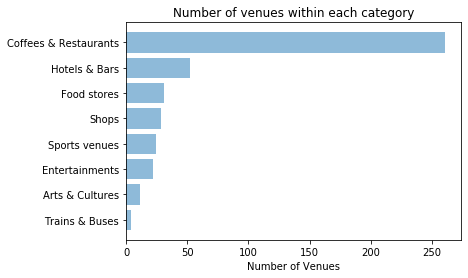

In [34]:
#Number of venues within each category

tmp = pd.DataFrame(dataframe['Venue Macro-Category'].value_counts(), index = None)
tmp['Category'] = tmp.index
tmp.reset_index(level=0, inplace=True)
tmp.rename(columns={"Venue Macro-Category": "Count"},inplace = True)
tmp = tmp.sort_values(by='Count', ascending=True)

plt.barh(np.arange(len(tmp['Category'])), tmp['Count'], align='center', alpha=0.5)
plt.yticks(np.arange(len(tmp['Category'])), tmp['Category'])
plt.xlabel('Number of Venues')
plt.title('Number of venues within each category')

plt.show()

Using a bar plot, we can see that the dominant category in our analysis is Coffees & Restaurants. However, very few tram stations are close (+ 500 meters) to other transport stations such as Trains & Buses. This can have at least one of the following meanings: 
 - Foursquare does not have enough information on Casablanca transport stations
 - The city of Casablanca has few transport lines 
 - Tram company must add stations closer to train and bus lines.

**Dominance of neighborhoods**

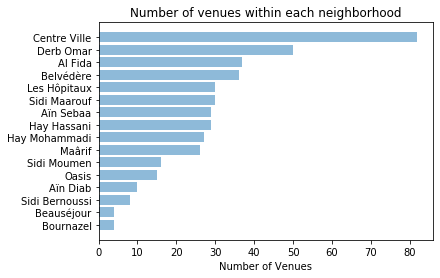

In [44]:
#Number of venues within each Neighborhood

tmp = pd.DataFrame(dataframe['Neighborhood'].value_counts(), index = None)
tmp.rename(columns={"Neighborhood": "Count"},inplace = True)
tmp['Neighborhood'] = tmp.index
tmp.reset_index(level=0, inplace=True)
tmp = tmp.sort_values(by='Count', ascending=True)

plt.barh(np.arange(len(tmp['Neighborhood'])), tmp['Count'], align='center', alpha=0.5)
plt.yticks(np.arange(len(tmp['Neighborhood'])), tmp['Neighborhood'])
plt.xlabel('Number of Venues')
plt.title('Number of venues within each neighborhood')

plt.show()

According to the number of venues within each neighborhood, the neighborhood “Centre ville” which literally means city center, is the most the most requested which is normal. The neighborhoods that follow it such as “Derb Omar” and “Al Fida” are popular districts where shops and coffees are very commons.

**Density of venues by stations**

Text(0, 0.5, 'Density')

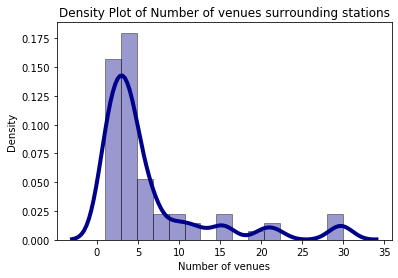

In [48]:
#Number of venues surrounding each station

tmp = pd.DataFrame(dataframe['Station'].value_counts(), index = None)
tmp.rename(columns={"Station": "Count"},inplace = True)
tmp['Station'] = tmp.index
tmp.reset_index(level=0, inplace=True)
tmp = tmp.sort_values(by='Count', ascending=True)

sns.distplot(tmp['Count'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of Number of venues surrounding stations')
plt.xlabel('Number of venues')
plt.ylabel('Density')

The following density plot shows that the majority of stations have a number of close venues between 1 and 5, which is very low. We can deduct from this analysis that:
 - Either Foursquare doesn’t have many registered venues of Casablanca,
 - Or tram stations mainly pass through residential areas
 - Or tram lines are not optimized.

**Neighborhoods and their top 5 common venue categories**

In [101]:
tmp_onehot = pd.get_dummies(dataframe[['Venue Macro-Category']], prefix="", prefix_sep="")
tmp_onehot['Neighborhood'] = dataframe['Neighborhood'] 

fixed_columns = [tmp_onehot.columns[-1]] + list(tmp_onehot.columns[:-1])
tmp_onehot = tmp_onehot[fixed_columns]

tmp_onehot.head()

,Neighborhood,Arts & Cultures,Coffees & Restaurants,Entertainments,Food stores,Hotels & Bars,Shops,Sports venues,Trains & Buses
0,Sidi Moumen,0,1,0,0,0,0,0,0
1,Sidi Moumen,0,1,0,0,0,0,0,0
2,Sidi Moumen,0,0,0,0,0,0,1,0
3,Sidi Moumen,0,0,0,0,0,0,1,0
4,Sidi Moumen,0,1,0,0,0,0,0,0


In [102]:
tmp_grouped = tmp_onehot.groupby('Neighborhood').mean().reset_index()

For more details, we have defined the top 5 common venue categories for each neighborhood. The result shows that the category Coffees & Restaurants is the 1st common venue category in almost all neighborhoods. For the rest of variables, the categories Shops, Entertainment & Sport Venues are very common.

In [103]:
def return_most_common_venues_category(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [128]:
num_top_venues_cat = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues_cat):
    try:
        columns.append('{}{} Most Common Venue category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue category'.format(ind+1))

# create a new dataframe
Neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighborhoods_venues_sorted['Neighborhood'] = tmp_grouped['Neighborhood']

for ind in np.arange(tmp_grouped.shape[0]):
    Neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues_category(tmp_grouped.iloc[ind, :], num_top_venues_cat)

Neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue category,2nd Most Common Venue category,3rd Most Common Venue category,4th Most Common Venue category,5th Most Common Venue category
0,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
1,Aïn Diab,Hotels & Bars,Coffees & Restaurants,Entertainments,Trains & Buses,Sports venues
2,Aïn Sebaa,Coffees & Restaurants,Shops,Entertainments,Food stores,Trains & Buses
3,Beauséjour,Coffees & Restaurants,Sports venues,Food stores,Trains & Buses,Shops
4,Belvédère,Coffees & Restaurants,Hotels & Bars,Shops,Sports venues,Food stores


<a id='item3_2'></a>

### 3.2 Clustering

Since we were going to use the clustering algorithm K-means, we had to define the most optimal K number of clusters for our dataset. We noticed that after 3 clusters, the groups no longer had meaning or were difficult to interpret; this is why we choose K = 3.

In [129]:
#Clustering with k = 3
k = 3
tmp_grouped_clustering = tmp_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(tmp_grouped_clustering)

In [130]:
Neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tmp_merged = DF
tmp_merged = tmp_merged.join(Neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tmp_merged

,Station,Line,Latitude,Longitude,Neighborhood,Borough,Cluster Labels,1st Most Common Venue category,2nd Most Common Venue category,3rd Most Common Venue category,4th Most Common Venue category,5th Most Common Venue category
0,Sidi Moumen,T1,33.587459,-7.500901,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
1,Nassim,T1,33.585144,-7.504294,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
2,Mohammed Zefzaf,T1,33.582373,-7.508647,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
3,Centre de maintenance,T1,33.579540,-7.513432,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
4,Hôpital Sidi Moumen,T1,33.576385,-7.518045,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
5,Attacharouk,T1,33.573866,-7.525059,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
6,Sidi Moumen - Okba Ibnou Nafi,T1,33.573113,-7.532503,Sidi Moumen,Sidi Moumen,0,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
7,Forces Auxiliaires,T1,33.574731,-7.539091,Bournazel,Sidi Moumen,0,Coffees & Restaurants,Shops,Entertainments,Trains & Buses,Sports venues
8,Hay Raja,T1,33.576784,-7.548366,Bournazel,Sidi Moumen,0,Coffees & Restaurants,Shops,Entertainments,Trains & Buses,Sports venues
9,Ibn Tachfine,T1,33.580939,-7.563200,Hay Mohammadi,Hay Mohammadi,0,Coffees & Restaurants,Sports venues,Shops,Hotels & Bars,Arts & Cultures


In [131]:
#Create the map using Casablanca geographical coodinates
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k+1)
ys = [i + x + (i*x)**2 for i in range(k+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tmp_merged['Latitude'], tmp_merged['Longitude'], tmp_merged['Station'], tmp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can distinguish the 3 clusters on the map from the color of stations. At first glance, the red cluster appears to be the group with the most stations while the purple and green clusters appear almost equal.

<a id='item4'></a>

## 4. Results

#### Cluster 1

Red Cluster: The size of the purple cluster represents 60% of the number of stations thus covering 10 neighborhoods out of 16. Its commons venues are Coffees & Restaurants and Food stores.

In [146]:
tmp_merged.loc[tmp_merged['Cluster Labels'] == 0, tmp_merged.columns[[0] + [4] + list(range(7, tmp_merged.shape[1]))]]                                                                                                                                  
                                                                                                                                  
                                                                                                                                  

,Station,Neighborhood,1st Most Common Venue category,2nd Most Common Venue category,3rd Most Common Venue category,4th Most Common Venue category,5th Most Common Venue category
0,Sidi Moumen,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
1,Nassim,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
2,Mohammed Zefzaf,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
3,Centre de maintenance,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
4,Hôpital Sidi Moumen,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
5,Attacharouk,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
6,Sidi Moumen - Okba Ibnou Nafi,Sidi Moumen,Coffees & Restaurants,Sports venues,Trains & Buses,Food stores,Shops
7,Forces Auxiliaires,Bournazel,Coffees & Restaurants,Shops,Entertainments,Trains & Buses,Sports venues
8,Hay Raja,Bournazel,Coffees & Restaurants,Shops,Entertainments,Trains & Buses,Sports venues
9,Ibn Tachfine,Hay Mohammadi,Coffees & Restaurants,Sports venues,Shops,Hotels & Bars,Arts & Cultures


In [145]:
tmp_merged.loc[tmp_merged['Cluster Labels'] == 0, tmp_merged.columns[[0] + [4] + list(range(7, tmp_merged.shape[1]))]].shape                                                                                                                                  
 

(42, 7)

#### Cluster 2

Purple Cluster: The size of the purple cluster represents 14% of the number of stations thus covering 4 neighborhoods out of 16. Its commons venues are Coffees & Restaurants and Hotels & Bars.

In [138]:
tmp_merged.loc[tmp_merged['Cluster Labels'] == 1, tmp_merged.columns[[0] + [4] + list(range(7, tmp_merged.shape[1]))]]                                                                                                                                  



,Station,Neighborhood,1st Most Common Venue category,2nd Most Common Venue category,3rd Most Common Venue category,4th Most Common Venue category,5th Most Common Venue category
15,Bahmad,Belvédère,Coffees & Restaurants,Hotels & Bars,Shops,Sports venues,Food stores
16,Gare de Casa-Voyageurs,Belvédère,Coffees & Restaurants,Hotels & Bars,Shops,Sports venues,Food stores
17,Place Al Yassir,Belvédère,Coffees & Restaurants,Hotels & Bars,Shops,Sports venues,Food stores
18,La Résistance,Belvédère,Coffees & Restaurants,Hotels & Bars,Shops,Sports venues,Food stores
19,Mohammed Diouri,Derb Omar,Coffees & Restaurants,Hotels & Bars,Food stores,Entertainments,Trains & Buses
20,Marché Central,Derb Omar,Coffees & Restaurants,Hotels & Bars,Food stores,Entertainments,Trains & Buses
21,Place des Nations-Unies,Centre Ville,Coffees & Restaurants,Hotels & Bars,Entertainments,Arts & Cultures,Sports venues
22,Place Mohammed V,Centre Ville,Coffees & Restaurants,Hotels & Bars,Entertainments,Arts & Cultures,Sports venues
23,Avenue Hassan II,Centre Ville,Coffees & Restaurants,Hotels & Bars,Entertainments,Arts & Cultures,Sports venues
37,Aïn Diab,Aïn Diab,Hotels & Bars,Coffees & Restaurants,Entertainments,Trains & Buses,Sports venues


#### Cluster 3

Green Cluster: The size of the purple cluster represents 26% of the number of stations thus covering 4 neighborhoods out of 16. Its commons venues are Coffees & Restaurants and Shops.

In [139]:
tmp_merged.loc[tmp_merged['Cluster Labels'] == 2, tmp_merged.columns[[0] + [4] + list(range(7, tmp_merged.shape[1]))]]                                                                                                                                  



,Station,Neighborhood,1st Most Common Venue category,2nd Most Common Venue category,3rd Most Common Venue category,4th Most Common Venue category,5th Most Common Venue category
24,Wafasalaf,Les Hôpitaux,Coffees & Restaurants,Shops,Hotels & Bars,Sports venues,Arts & Cultures
25,Faculté de Médecine,Les Hôpitaux,Coffees & Restaurants,Shops,Hotels & Bars,Sports venues,Arts & Cultures
26,Abdelmoumen,Les Hôpitaux,Coffees & Restaurants,Shops,Hotels & Bars,Sports venues,Arts & Cultures
50,Anoual,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
51,Hermitage,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
52,2 mars,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
53,El Fida,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
54,Place Sraghna,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
55,Derb Sultan,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses
56,Hay Farah,Al Fida,Coffees & Restaurants,Shops,Food stores,Sports venues,Trains & Buses


We can deduce that the most requested neighborhoods which needs more tram stations are the district which contains coffees, restaurants, shops and hotels.

<a id='item5'></a>

## 5. Discussion

Foursquare API is a very interesting API but unfortunately not very popular in all countries. Indeed, according to our analysis, the venues and places of Casablanca existing in its database are mainly coffee shops & restaurants. We couldn’t find any work areas which somewhat impacted oud analysis. Work areas require a lot of tram and bus stations which would be very useful for us. However, we cannot blame the API only. It is true that the city of Casablanca – despite being a large city and an economic capital of Morocco- had a lack of transport lines and places of entertainment. 

<a id='item6'></a>

## 6. Conclusion

Through this project, we have tried to group the tram stations according to their surroundings and neighborhoods in order to have an idea on optimizing routes for future stations. Data analysis and clustering allowed us to describe the similarities between stations and the most common venues in the city. The result shows that coffee shops, restaurants, hotels and shops and very present in Casablanca which can be beneficial for Casa Tramway. However, as mentioned in the previous section, many important information is missing due to the unpopularity of the Foursquare App in Morocco. The result could be more promising if residential areas and work areas where listed in Foursquare. 